In [1]:
'''
Read the stack from the ./data/stacks/stack.pkl file
and generate the interferograms network that will be used
for the interferograms generation
'''

#%% import the reuired libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

#% Read the stack from the ./data/stack.pkl file
with open('./data/stack.pkl', 'rb') as f:
    stack = pickle.load(f)

stack = stack[0]

In [2]:
#%% Loop twice over the stack and get the all possible interforemtric pairs
inter_pairs = []
for i in stack:
    for j in stack:
        if i != j:
            slave_1 = i.properties['fileID']
            t_bl_s1 = i.properties['temporalBaseline']
            p_bl_s1 = i.properties['perpendicularBaseline']
            geo_s1 = i.geometry

            slave_2 = j.properties['fileID']
            t_bl_s2 = j.properties['temporalBaseline']
            p_bl_s2 = j.properties['perpendicularBaseline']
            geo_s2 = j.geometry

            t_bl = np.abs(t_bl_s1 - t_bl_s2)
            p_bl = np.abs(p_bl_s1 - p_bl_s2)

            # Double check to prevent creating list between two identical frames
            if slave_1 != slave_2: 
                inter_pairs.append([slave_1, slave_2, t_bl, p_bl, t_bl_s1, 
                                    p_bl_s1, t_bl_s2, p_bl_s2, geo_s1, geo_s2])
            else:
                print("Super master frame: %s %s" %(slave_1, slave_2))

In [3]:
# Remove repeated pairs
for i in inter_pairs:
    file1_id = i[0]
    file2_id = i[1]
    for j in inter_pairs:
        if file2_id == j[0] and file1_id == j[1]:
            inter_pairs.remove(j)

# Filter the interferometric pairs based on the temporal and perpendicular
#  baselines temporal baseline should be less than 150 days and the perpendicular
# baseline should be less than 150 m
sbas_pairs = []
for i in inter_pairs:
    if i[2] < 100 and i[3] < 100 and np.abs(i[5]) < 150 and np.abs(i[7]) < 150:
        sbas_pairs.append(i)

# Print the length of the SBAS pairs
print(len(sbas_pairs))

# Save the sbas interferometric pairs to a pickle file
with open('./data/sbas_inter_pairs.pkl', 'wb') as f:
    pickle.dump(sbas_pairs, f)

1311


Text(0.5, 1.0, 'Temporal vs. Perpendicular Baselines of the Stack')

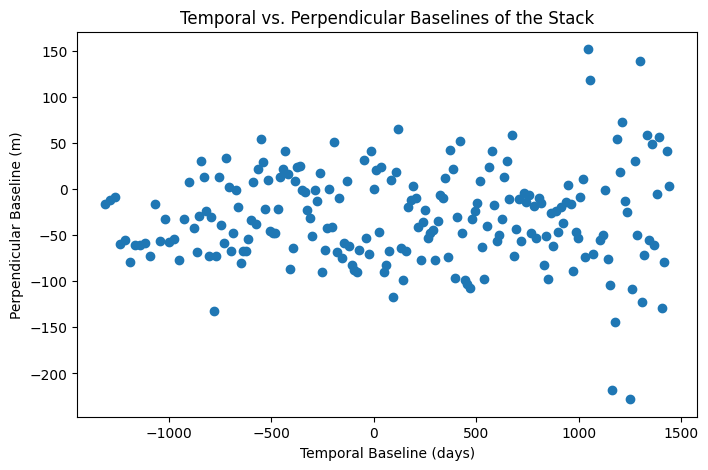

In [4]:
#%% Loop over the stack and get the prependical and temporal baselines and 
# store them in a lists then plot them 
pp_ls = []
tm_ls = []
for i in stack:
    pp_ls.append(i.properties['perpendicularBaseline'])
    tm_ls.append(i.properties['temporalBaseline'])

plt.figure(figsize=(8,5), dpi=100)
plt.plot(tm_ls, pp_ls, 'o')
plt.xlabel('Temporal Baseline (days)')
plt.ylabel('Perpendicular Baseline (m)')
plt.title('Temporal vs. Perpendicular Baselines of the Stack')

Text(0.5, 1.0, 'Temporal vs. Perpendicular Baselines of the Stack')

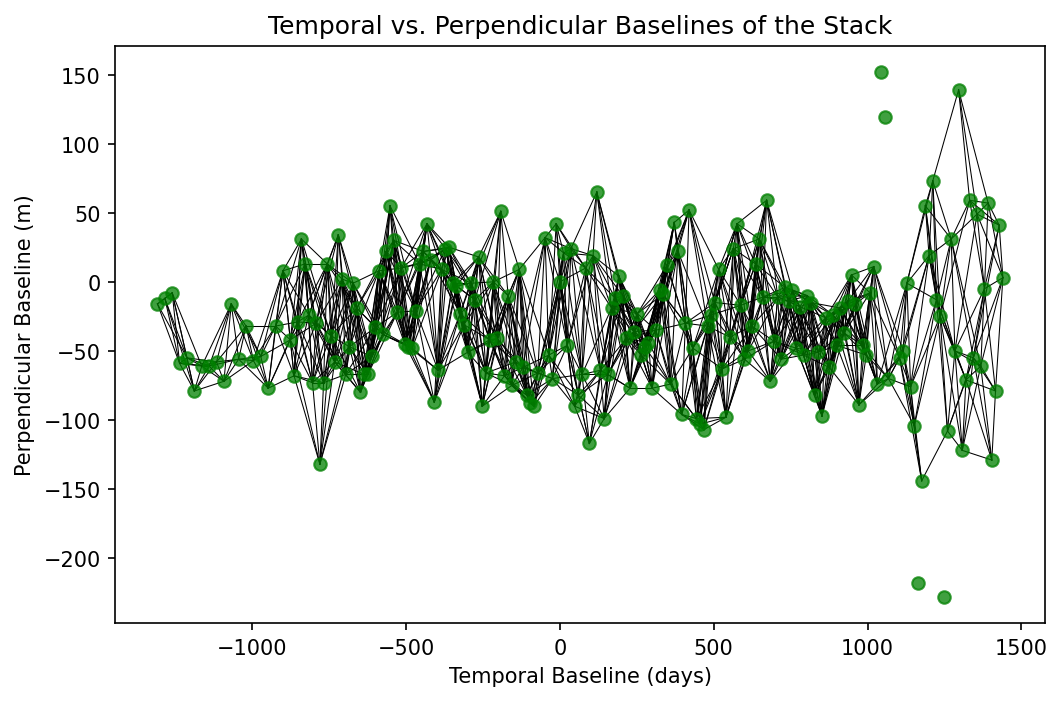

In [5]:
#%% Plot the temporal and perpendicular baselines of the interferometric pairs
# as lines between the two points of each pair on top of the scatter plot
plt.figure(figsize=(8,5), dpi=150)
for i in sbas_pairs:
    plt.plot([i[4], i[6]], [i[5], i[7]], 'k-', linewidth=0.5)

plt.plot(tm_ls, pp_ls, 'go', alpha=0.75)
plt.xlabel('Temporal Baseline (days)')
plt.ylabel('Perpendicular Baseline (m)')
plt.title('Temporal vs. Perpendicular Baselines of the Stack')

In [6]:
# Now calculate the optimal interferometric master
# 1. Calculate the temporal baseline between all image pairs
# 2. Calculate the perpendicular baseline between all image pairs
# 3. Find the minimum temporal + prependicular baseline

# 1. Calculate the temporal baseline between all image pairs
tbl_pbl_lst = []
for i in stack:
    tbl_val = 0
    pbl_val = 0
    for j in stack:
        if i != j:
            slave_1 = i.properties['fileID']
            t_bl_s1 = i.properties['temporalBaseline']
            p_bl_s1 = i.properties['perpendicularBaseline']

            slave_2 = j.properties['fileID']
            t_bl_s2 = j.properties['temporalBaseline']
            p_bl_s2 = j.properties['perpendicularBaseline']

            t_bl = np.abs(t_bl_s1 - t_bl_s2)
            p_bl = np.abs(p_bl_s1 - p_bl_s2)

            # Double check to prevent creating list between two identical frames
            if slave_1 != slave_2: 
                tbl_val += t_bl
                pbl_val += p_bl

    tbl_pbl_lst.append([tbl_val, pbl_val, i.properties['fileID']])

# Get the minimum temporal + perpendicular baseline
tbl_pbl_arr = np.array(tbl_pbl_lst)
min_idx = np.argmin(tbl_pbl_arr[:,0].astype('float') + tbl_pbl_arr[:,1].astype('float'))
master = tbl_pbl_arr[min_idx, 2]
print('-----------------------------------------------')
print('The optimal interferometric master is: ', master)
print('-----------------------------------------------')

# Get the master from the stack
for i in stack:
    if i.properties['fileID'] == master:
        master_frame = i
        break

m_pbl = master_frame.properties['perpendicularBaseline']
m_tbl = master_frame.properties['temporalBaseline']
print(m_pbl)
print(m_tbl)

-----------------------------------------------
The optimal interferometric master is:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0-SLC
-----------------------------------------------
-41
216


In [7]:
# Get the interferometric pairs by making a pair between the master and the rest
psi_pairs = []
tm_ls = []
pp_ls = []
k = 1
for i in stack:
    if i.properties['fileName'] != master:
        master = master_frame.properties['fileName']
        tbl_m = master_frame.properties['temporalBaseline'] - m_tbl
        pbl_m = master_frame.properties['perpendicularBaseline'] - m_pbl
        geo_m = master_frame.geometry

        slave = i.properties['fileName']
        tbl_s = i.properties['temporalBaseline'] - m_tbl
        pbl_s = i.properties['perpendicularBaseline'] - m_pbl
        geo_s = i.geometry

        t_bl = np.abs(tbl_s - tbl_m)
        p_bl = np.abs(pbl_s - pbl_m)

        tm_ls.append(tbl_s)
        pp_ls.append(pbl_s)

        psi_pairs.append([master, slave, t_bl, p_bl, tbl_m, pbl_m, tbl_s, pbl_s,
                          geo_m, geo_s])

        print("Master: ", master,  "Slave {}: ".format(k), slave)
        k += 1
    else:
        tm_ls.append(tbl_m)
        print(tbl_m)
        pp_ls.append(tbl_m)
        print(tbl_m)

print('-----------No of PSI pairs: {}-----------'.format(len(psi_pairs)))


Master:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 1:  S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip
Master:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 2:  S1A_IW_SLC__1SDV_20151220T155541_20151220T155609_009127_00D200_592C.zip
Master:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 3:  S1A_IW_SLC__1SSV_20160113T155540_20160113T155608_009477_00DC01_C8CD.zip
Master:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 4:  S1A_IW_SLC__1SSV_20160206T155540_20160206T155607_009827_00E62A_6625.zip
Master:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 5:  S1A_IW_SLC__1SSV_20160301T155539_20160301T155607_010177_00F047_BDD2.zip
Master:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 6:  S1A_IW_SLC__1SSV_20160325T155540_20160325T155608_010527_00FA3A_4B4D.zip
Master:  S1A_IW_SLC__1

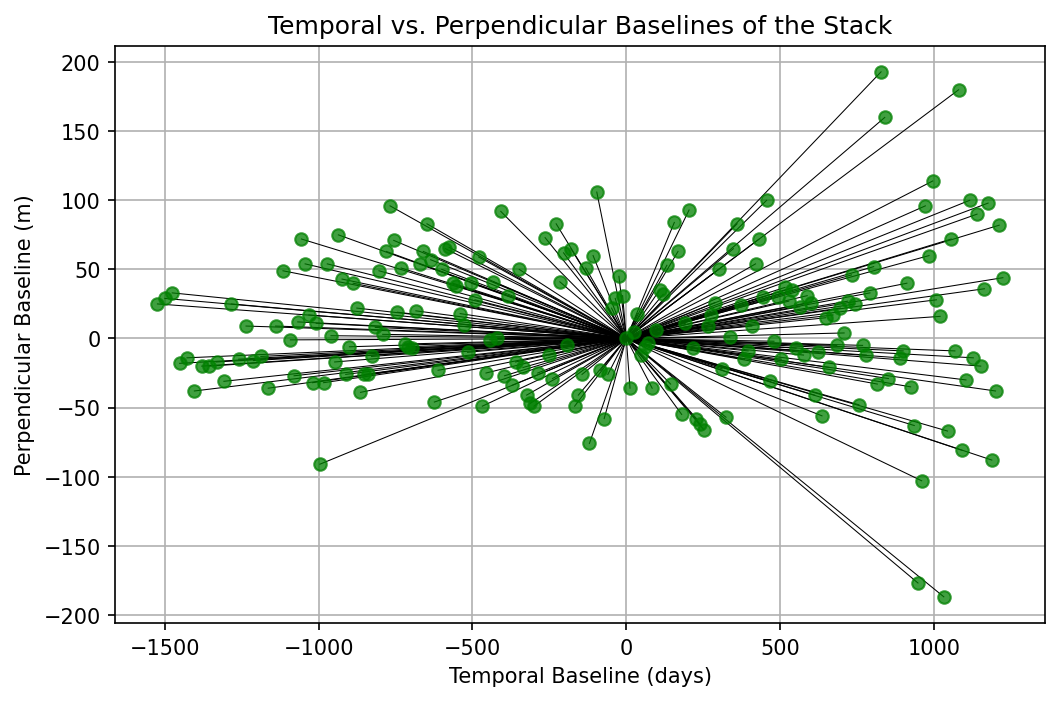

In [8]:
# Plot the temporal and perpendicular baselines of the interferometric pairs
# for only possible PSI pairs with prependicular baseline equal to zero
# to one of the frames
plt.figure(figsize=(8,5), dpi=150)

for i in psi_pairs:
    plt.plot([i[4] , i[6]], [i[5] , i[7]], 'k-', linewidth = 0.5)

plt.plot(tm_ls, pp_ls, 'go', alpha=0.75)
plt.grid()
plt.xlabel('Temporal Baseline (days)')
plt.ylabel('Perpendicular Baseline (m)')
plt.title('Temporal vs. Perpendicular Baselines of the Stack')
plt.show()

In [9]:
# Save the psi interferometric pairs to a pickle file
with open('./data/psi_inter_pairs.pkl', 'wb') as f:
    pickle.dump(psi_pairs, f)